In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from childes_mi.utils.paths import PHONBANK_DFS, DATA_DIR
from childes_mi.utils.general import flatten

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
phone_df = pd.read_pickle(PHONBANK_DFS/'phone_df_french.pickle')

In [5]:
phone_df['n_phones'] = [len(list(flatten(i))) for i in phone_df.phones.values]

In [6]:
phone_df[:3]

,name,transcript_id,age,dataset,language,sex,phones,orthography,xml_loc,n_phones
0,0,011015,1.833,Yamaguchi,fra,male,"[[None], [None], [None], [None], [None], [None...","[[www], [www], [www], [www], [www], [www], [ww...",/mnt/cube/tsainbur/Projects/github_repos/child...,585
0,0,030015,3.000,Yamaguchi,fra,male,"[[None], [eta, eta, lela], [ø, nɔ̃, la], [aɖɔ̃...","[[www], [éteins, éteins, lumière], [euh, non, ...",/mnt/cube/tsainbur/Projects/github_repos/child...,1760
0,0,020112,2.083,Yamaguchi,fra,male,"[[None], [None], [nɔ], [nɔ̃], [nɑ̃], [nɔ̃], [N...","[[www], [www], [non], [non], [non], [non], [ww...",/mnt/cube/tsainbur/Projects/github_repos/child...,488


In [7]:
phone_df.dataset.unique()

array(['Yamaguchi', 'GoadRose', 'Hunkeler', 'KernFrench', 'Lyon', 'Paris'],
      dtype=object)

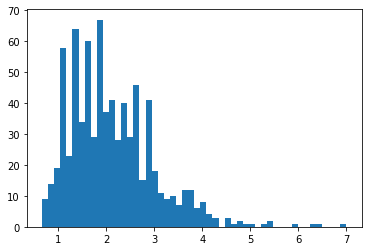

In [8]:
plt.hist(phone_df.age.values, bins = 50);

In [9]:
print("There are {} phones in this dataset".format(np.sum(phone_df.n_phones)))

There are 564678 phones in this dataset


In [10]:
import seaborn as sns
from childes_mi.utils.paths import DATA_DIR, FIGURE_DIR, ensure_dir
from childes_mi.utils.general import flatten,save_fig
ensure_dir(FIGURE_DIR/ 'distributions')

/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


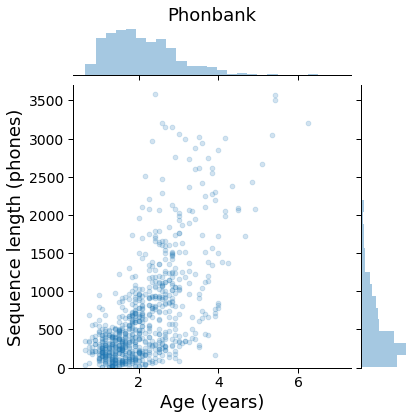

In [11]:
sns.set_context("paper", rc={"font.size":24,"axes.titlesize":18,"axes.labelsize":18, "axes.ticksize":14})   

p = sns.jointplot("age", "n_phones", data=phone_df, alpha=0.2, annot_kws={"size": 16})

p.set_axis_labels(xlabel="Age (years)", ylabel="Sequence length (phones)")
p.ax_joint.tick_params(labelsize=14)
p.ax_marg_x.set_title("Phonbank")
p.ax_joint.set_ylim([0,3700])
#save_fig(FIGURE_DIR/ 'distributions' / 'phonbank_distribution')
plt.show()

In [12]:
np.median(phone_df.n_phones)

441.0

## MI
- for each sequence, calculate the decay of a sequence as a function of distance between elements for that sequence indiividually
- Treat each phoneme as unique for that child, and compute MI across children

In [13]:
from childes_mi.information_theory import mutual_information as mi

In [14]:
distances = np.arange(1,101)

#### Run MI by age cohort

In [15]:
phone_df[:3]

,name,transcript_id,age,dataset,language,sex,phones,orthography,xml_loc,n_phones
0,0,011015,1.833,Yamaguchi,fra,male,"[[None], [None], [None], [None], [None], [None...","[[www], [www], [www], [www], [www], [www], [ww...",/mnt/cube/tsainbur/Projects/github_repos/child...,585
0,0,030015,3.000,Yamaguchi,fra,male,"[[None], [eta, eta, lela], [ø, nɔ̃, la], [aɖɔ̃...","[[www], [éteins, éteins, lumière], [euh, non, ...",/mnt/cube/tsainbur/Projects/github_repos/child...,1760
0,0,020112,2.083,Yamaguchi,fra,male,"[[None], [None], [nɔ], [nɔ̃], [nɑ̃], [nɔ̃], [N...","[[www], [www], [non], [non], [non], [non], [ww...",/mnt/cube/tsainbur/Projects/github_repos/child...,488


In [16]:
age_cohorts = [[0.5, 1], [1, 1.5], [1.5, 2], [2, 2.5], [2.5, 3], [3, 20]]

In [17]:
### sequence length by cohort

In [18]:
def concat(arr):
    """ingore concatenation of zero length list"""
    if len(arr) ==0:
        return []
    else:
        return np.concatenate(arr)

In [19]:
def remove_repeats(sequence):
    if len(sequence) == 0:
        return sequence
    a = np.array(sequence[1:])
    b = np.array(sequence[:-1])
    c = [sequence[0]] + list(a[a != b])
    return c

In [20]:
for (age_cohort_low, age_cohort_high) in tqdm(age_cohorts):
    cohort_subset = phone_df[
        (phone_df.age > age_cohort_low) & (phone_df.age <= age_cohort_high)
    ]
    
    median_n_phones = np.median(cohort_subset.n_phones.values)
    print(age_cohort_low, age_cohort_high, median_n_phones)

0.5 1 278.0
1 1.5 243.0
1.5 2 364.0
2 2.5 724.0
2.5 3 1014.0
3 20 1626.0



In [21]:
def quickplot_decay(distances, MI, shuff_MI, title=''):
    fig,axs = plt.subplots(ncols=2, figsize = (10,4))
    ax = axs[0]
    ax.set_title(title)
    ax.scatter(distances, MI-shuff_MI)
    ax.plot(distances, MI-shuff_MI, alpha = 0)
    ax.set_yscale('log')
    ax.set_xscale('log')

    ax = axs[1]
    ax.scatter(distances, MI)
    ax.scatter(distances, shuff_MI)
    plt.show()

In [22]:
cohort_subset[:4]

,name,transcript_id,age,dataset,language,sex,phones,orthography,xml_loc,n_phones
0,0,030212,3.167,Yamaguchi,fra,male,"[[None], [nɔ̃], [nɔ̃, je, pa, ɑ̃vi], [nɔ̃, je,...","[[www], [non], [non, j'ai, pas, envie], [non, ...",/mnt/cube/tsainbur/Projects/github_repos/child...,1519
0,0,030909,3.750,Yamaguchi,fra,male,"[[None], [pit, py], [nɑ̃], [se, av], [dɛm, pa,...","[[www], [yyy, yyy], [non], [yyy, yyy], [j'aime...",/mnt/cube/tsainbur/Projects/github_repos/child...,1378
0,0,030113,3.083,Yamaguchi,fra,male,"[[eta, li, la], [eta, li, la], [alym, a, lila]...","[[éteins, la, lumière], [éteins, la, lumière],...",/mnt/cube/tsainbur/Projects/github_repos/child...,1247
0,0,030312,3.250,Yamaguchi,fra,male,"[[None], [None], [ta, fe, puʧ], [a, pete, do, ...","[[www], [www], [t'as, fait, pout@o], [a, pété,...",/mnt/cube/tsainbur/Projects/github_repos/child...,968


In [23]:
!pip install --upgrade joblib

Requirement already up-to-date: joblib in /home/AD/tsainbur/anaconda3/lib/python3.7/site-packages (1.0.1)


3 20 1626
phones list: n ɔ ̃ n ɔ ̃ j e p a ɑ ̃ v i n ɔ ̃ j e p a ɑ ̃ v e n ɔ ̃ d e d e p a ɑ ̃ v e a b y z o n ɔ ̃ t e k a 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1626 out of 1626 | elapsed:  3.9min finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1626 out of 1626 | elapsed:  4.3min finished


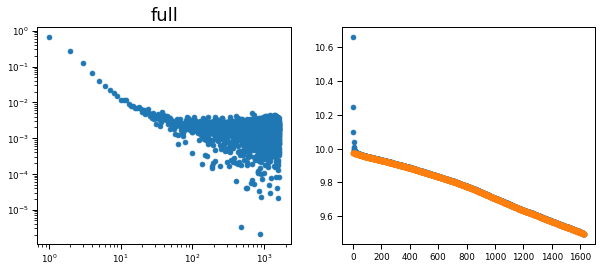

2.5 3 1014
phones list: e t a e t a l e l a ø n ɔ ̃ l a a ɖ ɔ ̃ e l ə b a l a o d a v a p u t k ɔ t a t e p ɔ ɕ ɔ p y ɕ k ə 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1014 out of 1014 | elapsed:  2.4min finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1014 out of 1014 | elapsed:  2.7min finished


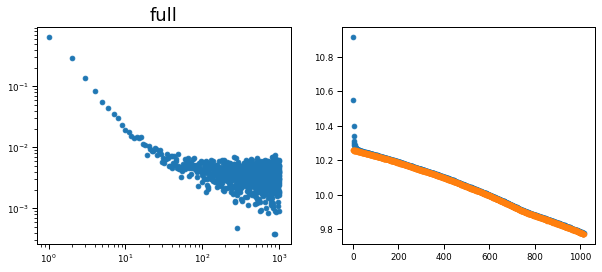

2 2.5 724
phones list: n ɔ n ɔ ̃ n ɑ ̃ n ɔ ̃ n ɔ ̃ n ɔ ̃ n ɔ ̃ n ɔ ̃ n ɑ ̰ ̃ n ɔ ̃ n ɔ ̃ n ɔ ̃ n ɔ ̃ n ɔ ̃ n ɔ ̃ n ɔ ̃ ə n 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 724 out of 724 | elapsed:  1.6min finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 724 out of 724 | elapsed:  1.8min finished


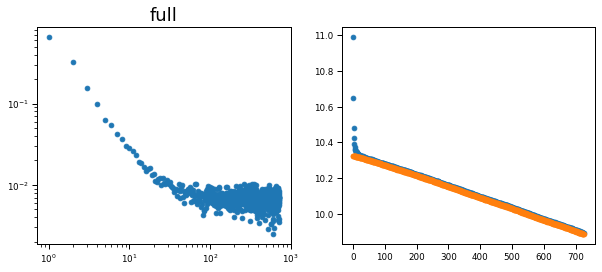

1.5 2 364
phones list: 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 364 out of 364 | elapsed:   50.5s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 364 out of 364 | elapsed:   55.4s finished


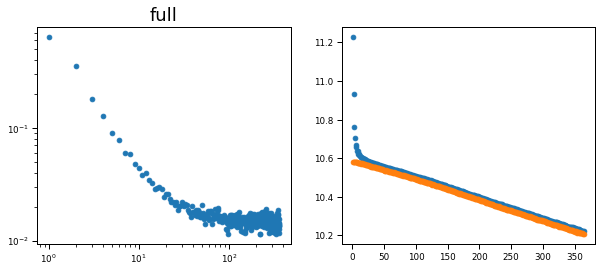

1 1.5 243
phones list: a ː ː ː β a β a a ʋ a m a m m m m m m m m m m m m m b w o ː ː g w o ː ː ː œ ː ː ʔ a ʔ ɔ ̃ ɔ ̃ a œ w 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed:   19.5s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed:   21.4s finished


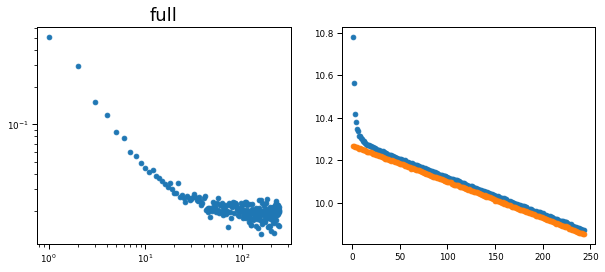

0.5 1 278
phones list: œ a ː œ œ a a ː œ ː œ œ a ː œ œ a ː a a j œ ː b e g œ ː a j a j œ j œ j œ ː a ː œ ː a œ ː o o œ ː e 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 278 out of 278 | elapsed:    5.9s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 278 out of 278 | elapsed:    6.5s finished


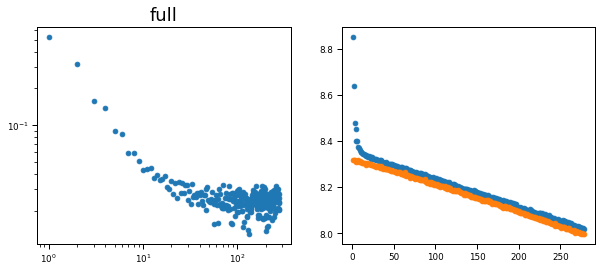

In [27]:
mi_df = pd.DataFrame(
    columns=[
        "MI",
        "MI_var",
        "shuff_MI",
        "shuff_MI_var",
        "distances",
        "age_cohort_low",
        "age_cohort_high",
        "n_phones",
        "n_unique_phones",
        "median_n_phones",
        'shuffling'
    ]
)
    # for each age cohort
for (age_cohort_low, age_cohort_high) in tqdm(age_cohorts[::-1]):
    cohort_subset = phone_df[
        (phone_df.age > age_cohort_low) & (phone_df.age <= age_cohort_high)
    ]
    
    median_n_phones = int(np.median(cohort_subset.n_phones.values))
    print(age_cohort_low, age_cohort_high, median_n_phones)

    ### make list of phones
    cohort_phones_list = [
        [
          i for i in "".join(flatten([i for i in flatten(row.phones) if i is not None]))
        ]
        for transcript_i, (idx, row) in enumerate(cohort_subset.iterrows())
    ]
    print('phones list:', [' '.join(i) for i in cohort_phones_list][0][:100])
    
    
    # get number of unique elements
    n_phones = len(np.concatenate(cohort_phones_list))
    n_unique_phones = 0 #len(np.unique(np.concatenate(cohort_phones)))
    
    distances = np.arange(1, np.max([100, median_n_phones]) + 1)
    
    # make each phone symbol specific to the transcript
    for transcript_i, (idx, row) in enumerate(cohort_subset.iterrows()):
        cohort_phones_list[transcript_i] = [str(transcript_i) + i for i in cohort_phones_list[transcript_i]]

    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        cohort_phones_list, distances=distances, n_jobs=None
    )
    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_phones,
        n_unique_phones,
        median_n_phones,
        'full'
    ]
    quickplot_decay(distances, MI, shuff_MI, title='full')

    
    mi_df.to_pickle(DATA_DIR / "mi" / "phonbank_mi_french.pickle")

In [28]:
mi_df[:3]

,MI,MI_var,shuff_MI,shuff_MI_var,distances,age_cohort_low,age_cohort_high,n_phones,n_unique_phones,median_n_phones,shuffling
0,"[10.663371043816312, 10.245082225102422, 10.09...","[0.004945938272197813, 0.0048637140946431075, ...","[9.97526238326807, 9.974438705111332, 9.974402...","[0.004820450882092466, 0.004817713571462185, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",3,20,359954,0,1626,full
1,"[10.915505015310265, 10.548361851654079, 10.39...","[0.004887922729166499, 0.004802003833059679, 0...","[10.256572952023603, 10.25706837629712, 10.257...","[0.004749013927682985, 0.004750348844609571, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",2.5,3,313197,0,1014,full
2,"[10.991623024066557, 10.646451779237823, 10.47...","[0.005196027243733277, 0.005117216935930317, 0...","[10.324423226440707, 10.325474461906364, 10.32...","[0.0050613373543492894, 0.005062582834832084, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",2,2.5,277162,0,724,full


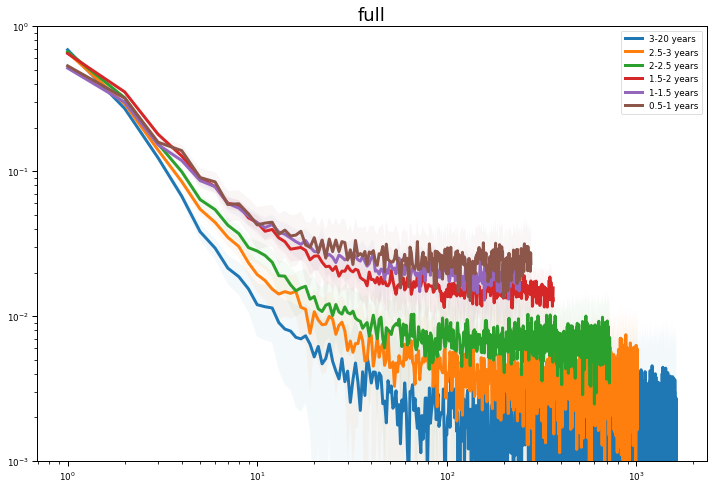

In [31]:
for shuff in ['full']:
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.set_title(shuff)
    for idx, row in mi_df.iterrows():
        if row.shuffling != shuff: 
            continue
        MI = row.MI-row.shuff_MI
        MI_var = row.MI_var
        #ax.scatter(distances, row.MI-row.shuff_MI)
        ax.plot(row.distances, row.MI-row.shuff_MI, label = '{}-{} years'.format(row.age_cohort_low, row.age_cohort_high), lw=3)
        ax.fill_between(row.distances, MI-MI_var, MI+MI_var, alpha = 0.05)

    ax.legend()
    ax.set_ylim([1e-3,1])
    #ax.set_xlim([1, 100])

    ax.set_yscale('log')
    ax.set_xscale('log')
    plt.show()

full


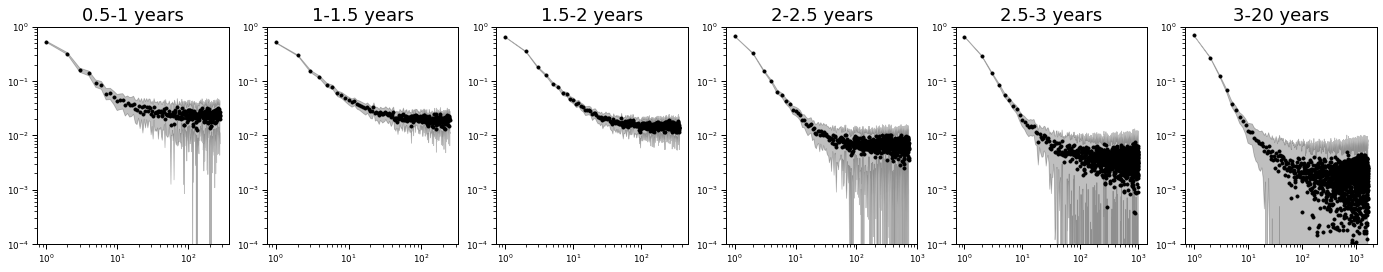

In [32]:
for shuff in ['full']:
    print(shuff)
    fig, axs = plt.subplots(ncols=len(age_cohorts), figsize=(4*len(age_cohorts),4))

    for axi, (idx, row) in enumerate(mi_df.iterrows()):
        if row.shuffling != shuff: 
            continue
        MI = row.MI-row.shuff_MI
        MI_var = row.MI_var
        #ax.scatter(distances, row.MI-row.shuff_MI)
        ax = axs[np.array([i[0] for i in age_cohorts]) == row.age_cohort_low][0]
        #ax.plot(distances, row.MI-row.shuff_MI, label = '{}-{} years'.format(row.age_cohort_low, row.age_cohort_high), lw=3)
        ax.scatter(row.distances, row.MI-row.shuff_MI, s=10, color='k')
        ax.fill_between(row.distances, MI-MI_var, MI+MI_var, alpha = 0.25, color= 'k')
        #ax.legend()
        ax.set_title('{}-{} years'.format(row.age_cohort_low, row.age_cohort_high))
        ax.set_ylim([1e-4,1])
        #ax.set_xlim([1, 100])

        ax.set_yscale('log')
        ax.set_xscale('log')
    plt.show()

full


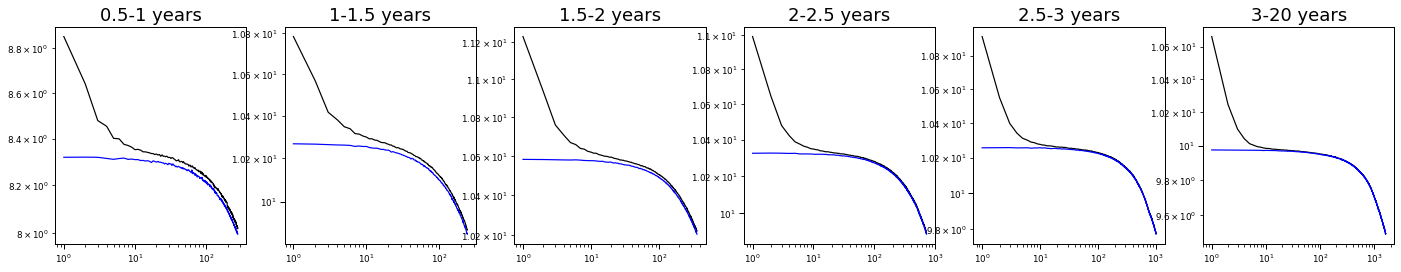

In [33]:
for shuff in ['full']:
    print(shuff)
    fig, axs = plt.subplots(ncols=len(age_cohorts), figsize=(4*len(age_cohorts),4))

    for axi, (idx, row) in enumerate(mi_df.iterrows()):
        if row.shuffling != shuff: 
            continue
        MI = row.MI-row.shuff_MI
        MI_var = row.MI_var
        #ax.scatter(distances, row.MI-row.shuff_MI)
        ax = axs[np.array([i[0] for i in age_cohorts]) == row.age_cohort_low][0]
        #ax.plot(distances, row.MI-row.shuff_MI, label = '{}-{} years'.format(row.age_cohort_low, row.age_cohort_high), lw=3)
        ax.plot(row.distances, row.MI, color='k')
        ax.plot(row.distances, row.shuff_MI, color='b')
        #ax.fill_between(row.distances, MI-MI_var, MI+MI_var, alpha = 0.25, color= 'k')
        #ax.legend()
        ax.set_title('{}-{} years'.format(row.age_cohort_low, row.age_cohort_high))
        #ax.set_ylim([1e-4,1])
        #ax.set_xlim([1, 100])

        ax.set_yscale('log')
        ax.set_xscale('log')
    plt.show()